# **Reinforcement Learning Project - BlackJack**


### In this project, we will try to identify the most effective game strategy for Blackjack through reinforcement learning. You will have the opportunity to investigate the fundamentals of Reinforcement Learning and explore various approaches.

## Objectives

Key aspects of this project

*   OpenAI Gym Environment Selection
*   Reinforcement Learning Concept Explanation
*   Blackjack Environment Training and Testing
*   Environment Setup
*   Learning Techniques
*   Experiment Logging
*   Comparisons and Analyses

----


## __Table of Contents__
<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li><a href="#Setup">Import Libraries and Setup</a>
    <li><a href="#Setup">Blackjack Environment</a>
    <li><a href="#Setup">Models</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Random</a></li>
            <li><a href="#Importing-Required-Libraries">MC (On-Policy) --> Learn from the top</a></li>
            <li><a href="#Importing-Required-Libraries">MC (Off-Policy) --> Learn from the tail </a></li>
            <li><a href="#Defining-Helper-Functions">QLearning</a></li>
             <li><a href="#Defining-Helper-Functions">Sarsa (Temporal Difference control)</a></li>
        </ol>
    </li>
</ol>


## 1. Objectives


### Define the objectives

## 2. Import Libraries and Setup 

### Importing Required Libraries

_We recommend you import all required libraries in one place (here):_


In [6]:
# !pip install gym==0.22.0 pygame
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import time
import torch
from tabulate import tabulate
from collections import namedtuple, deque, defaultdict
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import sys
sys.path.append('..') 

from src.features.blackjackutility import game_result, average_wins, games_with_policy, reward_function, draw_till_17_pol, create_epsilon_greedy_action_policy, create_random_policy, create_greedy_action_policy
from src.visualization.visualize import plot_value_function, plot_policy_blackjack, training_results, create_grids, create_plots, calc_payoffs, plot_policy, plot_value_function
from src.models.MonteCarlo import monte_carlo_ES, monte_carlo, On_pol_mc_control_learn, Off_pol_mc_control_learn
from src.models.QLearning import QLearningAgent, off_pol_TD_Q_learn
from src.models.Sarsa import SarsaAgent, SARSA

## 3. Blackjack Environment

We create an openAI gym blackjack enviroment by calling gym method through the use of Make function.


In [7]:
environment = gym.make("Blackjack-v1", sab = True)

Now, it's time to explore the observation space in our environment. The observation space represents the set of all conceivable states, and we can access this space using the observation_space method

In [8]:
print(environment.observation_space)
print(environment.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


This can be described as:

States -> Tuple(Discrete(32), Discrete(11), Discrete(2)) where:
* The player's card sum can range from the lowest (1) to the highest (11, 10, 11), resulting in 32 possible states.
* The dealer's face-up card can take values between 1 and 11.
* The 'usable Ace' space can be either True or False, equating to 2 possible states.

    Hence, there are a total of 704 possible states, computed as: $32 \times 11 \times 2 = 704$. 

Actions -> [0,1]
* Either stand or hit: [0,1] i.e 0 for stand , 1 for hit


In [9]:
state = environment.reset()
print("s_{} = {}".format(0, environment.observation_space.sample())) 

s_0 = (31, 8, 0)


Let's see more possible states:


In [10]:
for i in range(15):
    print("s_{} = {}".format(i, environment.observation_space.sample()))

s_0 = (21, 9, 1)
s_1 = (0, 4, 0)
s_2 = (13, 10, 0)
s_3 = (4, 2, 0)
s_4 = (24, 3, 0)
s_5 = (14, 8, 0)
s_6 = (8, 5, 1)
s_7 = (7, 6, 1)
s_8 = (26, 2, 0)
s_9 = (1, 9, 0)
s_10 = (22, 2, 0)
s_11 = (17, 10, 1)
s_12 = (18, 7, 1)
s_13 = (14, 10, 0)
s_14 = (14, 8, 1)


In [11]:
for t in range(10):
    action=environment.action_space.sample()
    if action:
        print("Hit, A_{} = {}".format(t,action))
    else:
        print("Stay",action)

Hit, A_0 = 1
Stay 0
Hit, A_2 = 1
Hit, A_3 = 1
Stay 0
Stay 0
Stay 0
Hit, A_7 = 1
Hit, A_8 = 1
Stay 0


Let's also check the player and dealers cards by using `environment.player` and `environment.dealer` function 


In [12]:
print(environment.observation_space.sample())
print(environment.player)
print(environment.dealer)

(10, 9, 1)
[10, 5]
[9, 10]


We will introduce a bit more terminology, **Episode** is a set of  agent-environment interactions from initial to final state, i.e it's one game that agent the plays. In addition, our agents are operating in a discrete-time game. Each time-advancing decision is a **step** (e.x. taking some action from some state). It's easy to see that each Episode consists of a series of steps. 

Let's play through some episodes of the game, choosing random actions for each step: 


In [13]:
episodes = 2

for agent_type in ["Conservador", "Neutro", "Agressivo"]:


    for episode in range(episodes):
        total_reward = 0
        state = environment.reset()
        done = False
        print("_________________________________________")
        print("Episode {} - Agent Type: {}".format(episode, agent_type))
        print("")
        print("Initial Agent's Cards: {}".format(environment.player))
        print("Dealer's Showing Card: {}".format(environment.dealer[0]))

        while not done:
            action = environment.action_space.sample()
            print("The Agent's current sum: {}, Agent's usable ace: {}".format(state[0], state[0]))
            print("")
            if action:
                print("Action: Hit")
            else:
                print("Action: Stand")

            custom_reward = reward_function(state, action, agent_type=agent_type, player_sum=state[0])
            print("Custom Reward for Agent Type {}: {}".format(agent_type, custom_reward))

            state, default_reward, done, info = environment.step(action)

            print("The Agent has the following cards: {}".format(environment.player))

            total_reward += custom_reward  # Correção: Adiciona a custom_reward em cada jogada

        # Exibe as cartas finais do dealer após cada episódio
        print("Dealer's Final Cards: {}".format(environment.dealer))
        print("")
        print("Default Reward: {}".format(default_reward))
        print("Total Custom Reward: {}".format(total_reward))  # Custom Reward para a última jogada
        print("Total Reward for Agent Type {}: {}".format(agent_type, total_reward + default_reward))  # Correção: Adiciona custom_reward + default_reward


_________________________________________
Episode 0 - Agent Type: Conservador

Initial Agent's Cards: [6, 2]
Dealer's Showing Card: 6
The Agent's current sum: 8, Agent's usable ace: 8

Action: Stand
Custom Reward for Agent Type Conservador: 0.3
The Agent has the following cards: [6, 2]
Dealer's Final Cards: [6, 8, 9]

Default Reward: 1.0
Total Custom Reward: 0.3
Total Reward for Agent Type Conservador: 1.3
_________________________________________
Episode 1 - Agent Type: Conservador

Initial Agent's Cards: [10, 10]
Dealer's Showing Card: 10
The Agent's current sum: 20, Agent's usable ace: 20

Action: Hit
Custom Reward for Agent Type Conservador: -0.2
The Agent has the following cards: [10, 10, 10]
Dealer's Final Cards: [10, 10]

Default Reward: -1.0
Total Custom Reward: -0.2
Total Reward for Agent Type Conservador: -1.2
_________________________________________
Episode 0 - Agent Type: Neutro

Initial Agent's Cards: [10, 5]
Dealer's Showing Card: 7
The Agent's current sum: 15, Agent's u

Run the code above a few more times and observe that our games are not really lucky. Try playing yourself, may be you can do better than a random action generator:


In [14]:
episodes = 10

for agent_type in ["Conservador", "Neutro", "Agressivo"]:


    for episode in range(episodes):
        total_reward = 0
        state = environment.reset()
        done = False
        print("_________________________________________")
        print("Episode {} - Agent Type: {}".format(episode, agent_type))
        print("")
        print("Initial Agent's Cards: {}".format(environment.player))
        print("Dealer's Showing Card: {}".format(environment.dealer[0]))

        while not done:
            action = environment.action_space.sample()
            print(state)
            print("The Agent's current sum: {}, Agent's usable ace: {}".format(state[0], state[2]))
            print("")
            if action:
                print("Action: Hit")
            else:
                print("Action: Stand")

            custom_reward = reward_function(state, action, agent_type=agent_type, player_sum=state[0])
            print("Custom Reward for Agent Type {}: {}".format(agent_type, custom_reward))

            state, default_reward, done, info = environment.step(action)

            print("The Agent has the following cards: {}".format(environment.player))

            total_reward += custom_reward  # Correção: Adiciona a custom_reward em cada jogada

        # Exibe as cartas finais do dealer após cada episódio
        print("Dealer's Final Cards: {}".format(environment.dealer))
        print("")
        print("Default Reward: {}".format(default_reward))
        print("Total Custom Reward: {}".format(total_reward))  # Custom Reward para a última jogada
        print("Total Reward for Agent Type {}: {}".format(agent_type, total_reward + default_reward))  # Correção: Adiciona custom_reward + default_reward


_________________________________________
Episode 0 - Agent Type: Conservador

Initial Agent's Cards: [4, 7]
Dealer's Showing Card: 1
(11, 1, False)
The Agent's current sum: 11, Agent's usable ace: False

Action: Stand
Custom Reward for Agent Type Conservador: 0.3
The Agent has the following cards: [4, 7]
Dealer's Final Cards: [1, 3, 9, 7]

Default Reward: -1.0
Total Custom Reward: 0.3
Total Reward for Agent Type Conservador: -0.7
_________________________________________
Episode 1 - Agent Type: Conservador

Initial Agent's Cards: [10, 6]
Dealer's Showing Card: 2
(16, 2, False)
The Agent's current sum: 16, Agent's usable ace: False

Action: Hit
Custom Reward for Agent Type Conservador: -0.2
The Agent has the following cards: [10, 6, 4]
(20, 2, False)
The Agent's current sum: 20, Agent's usable ace: False

Action: Stand
Custom Reward for Agent Type Conservador: 0.1
The Agent has the following cards: [10, 6, 4]
Dealer's Final Cards: [2, 1, 5]

Default Reward: 1.0
Total Custom Reward: -0.

At first we will start by exploring what greedy policy is and does:


### Epsilon-Greedy Policy

If you remember, as was mentioned before, policy is just a function that defines which action our agent should take based on the current state. In our environment, a simple deterministic policy $\pi$ for the the state $(15,10,0)$ may look like: 

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0EP1EN/Screenshot%202022-11-23%20at%2010.36.45%20AM.png" width="50%" alt="iris image">


You may ask why wouldn't we always use the best action, the action with the best estimated reward, what's the point of this epsilon constant. For it we will have to learn about 2 more concepts: 
 
* **Exploration** happens when the agent takes the random action to explore more opportunities, gather more information about possible actions and the environment.
* **Exploitation** happens when the agent makes the best decision given current information, it uses the best estimated action to maximize the reward. 

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0EP1EN/Screenshot%202022-11-23%20at%2010.51.11%20AM.png" width="50%" alt="iris image">

As demonstrated in the diagram above, **Epsilon** defines the trade-off between Exploration and Exploitation.  We need it because the best long-term strategy may involve short-term sacrifices and in most cases, agents must explore the environment and gather enough information to make the best overall decisions. It may save our agent from doing decisions that work instead of finding the best actions. 

Let's define a new python function that will follow the epsilon probability and return an action:


## 4. Models

### 4.1 Basic Naive Strategy

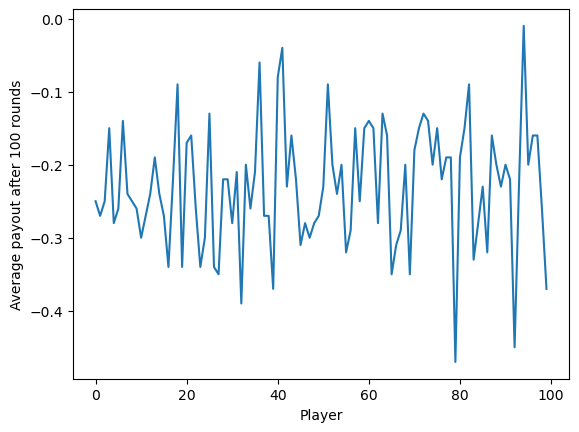

Average payout of a player after 100 rounds is -0.22959999999999994


-0.22959999999999994

In [15]:
def random_policy(obs, action_space):
    return [action_space.sample()]

environment.reset()
calc_payoffs(environment,100,100,lambda obs: random_policy(obs, environment.action_space))

In [16]:
average_random, std_win_random = average_wins(environment, episodes=200000)
print("Average wins:", average_random)
print("Standard wins:", std_win_random)

Average wins: 0.283385
Standard wins: 0.0010076654746864159


### 4.2 Monte Carlo Method

Monte Carlo methods in the context of Reinforcement Learning are a class of algorithms that learn directly from episodes of experience without requiring a model of the environment's dynamics. 

Both methods are iterative and require many episodes of interaction with the environment to accurately estimate the action-value function Q. The main difference lies in how they generate episodes (on-policy uses the policy that's being evaluated to make decisions, while off-policy uses a different policy) and how they weigh the returns (off-policy uses importance sampling to adjust for the difference in policies).

- On-Policy (Learn from the top): Refers to learning from the entire episode, starting from the top (beginning of the episode).

- Off-Policy (Learn from the tail): Refers to learning from the tail end of the episode, emphasizing the importance of the ending part of the trajectory, which is critical for importance sampling.

#### 4.2.1 MC (On-Policy) --> Learn from the top
The On_pol_mc_control_learn function implements the on-policy method, which means the policy being improved is the same one used to generate the data.

1. Epsilon-Greedy Policy: It uses an epsilon-greedy policy, which means that most of the time it exploits the best-known action but occasionally explores by choosing randomly among all actions. The epsilon parameter controls the balance between exploration and exploitation.

2. Episode Generation: Each episode is a sequence of states, actions, and rewards from the environment, generated according to the epsilon-greedy policy.

3. Policy Improvement: After each episode, for each state-action pair encountered, the function computes a return (total discounted rewards from that state-action onwards) and updates the action-value function Q accordingly. The policy is then improved by making it more greedy with respect to Q.

4. First-Visit MC: This function uses the first-visit MC approach, meaning it only considers the first time a state-action pair is visited in an episode for updating the value of Q.

In [29]:
environment.reset()
Q_on_pol,On_MC_Learned_Policy = On_pol_mc_control_learn(environment, 100, 0.9, 0.05)

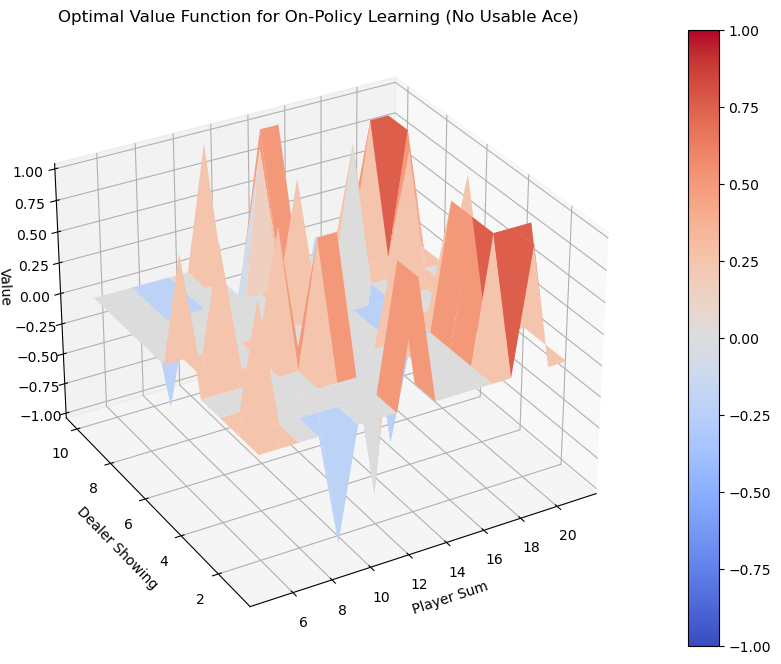

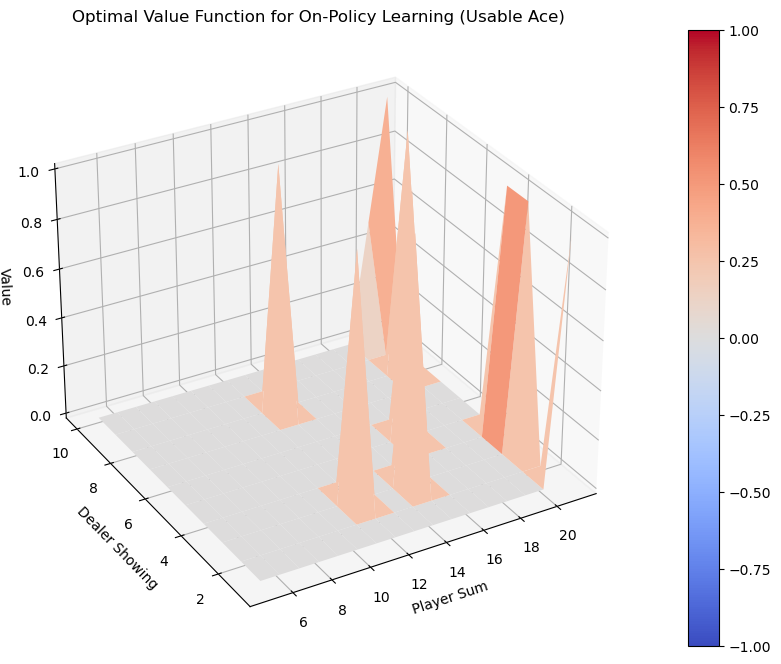

In [30]:
V = defaultdict(float)
for state, actions in Q_on_pol.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function for On-Policy Learning")

On-Policy MC Learning Policy


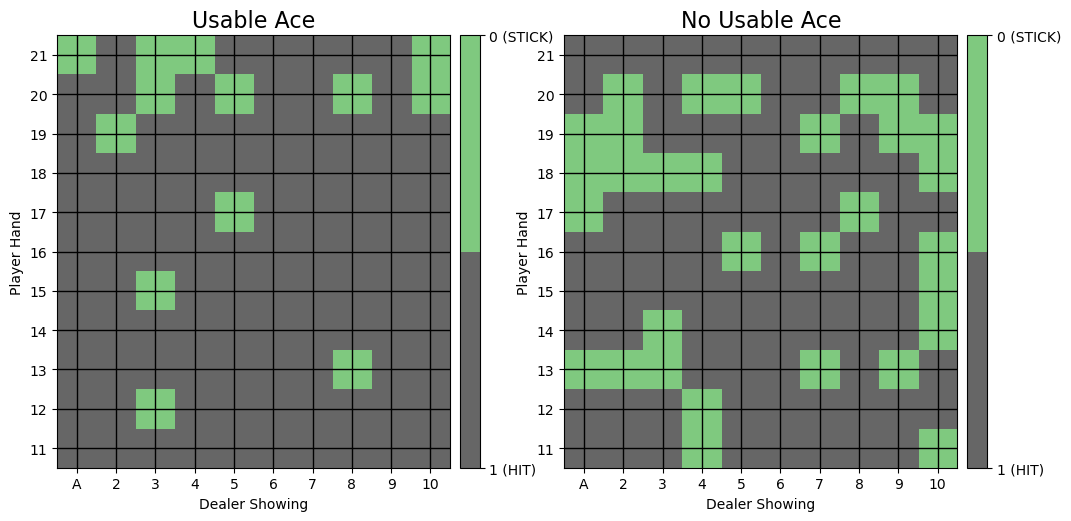

In [31]:
on_pol = {key: np.argmax(On_MC_Learned_Policy(key)) for key in Q_on_pol.keys()}
print("On-Policy MC Learning Policy")
plot_policy(on_pol)

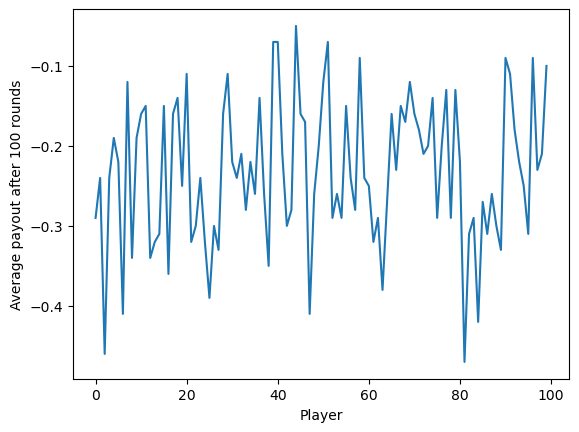

Average payout of a player after 100 rounds is -0.23249999999999993


-0.23249999999999993

In [32]:
#Payoff for On-Policy MC Trained Policy
environment.reset()
calc_payoffs(environment,100,100,On_MC_Learned_Policy)

In [33]:
average_mc_onpolicy, std_win_mc_onpolicy = average_wins(environment, episodes=200000)
# coloca isto num tabulate

# Create the table
table_data = [
    ["Average wins", f"{average_mc_onpolicy:.2%}"],
    ["Standard deviation of wins", f"{std_win_mc_onpolicy:.2%}"]
]

# Imprimindo a tabela
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt="pretty"))

Average wins: 0.28158
Standard wins: 0.0010057154259530874


#### 4.2.2 MC (Off-Policy) --> Learn from the tail
The Off_pol_mc_control_learn function, on the other hand, is an off-policy method. It learns the value of the optimal policy independently of the agent's actions by using importance sampling.

1. Behavior vs. Target Policy: There's a distinction between the behavior policy (used to generate episodes) and the target policy (the one that's being improved and estimated). The behavior policy generates the behavior, while the target policy is the one that gets updated towards optimality.

2. Weighted Importance Sampling: It uses weighted importance sampling to evaluate and improve the target policy based on the episodes generated by the behavior policy. This corrects for the difference in probability of the trajectories under the two policies.

3. Policy Improvement: The Q values are updated using the importance sampling ratios, which weight the returns based on how likely the actions are under the target policy versus the behavior policy.

In [34]:
environment.reset()
rand = create_random_policy(environment.action_space.n)
Q_off_Pol,off_MC_Learned_Policy = Off_pol_mc_control_learn(environment, 500000, rand,0.9)

Episode 500000/500000.

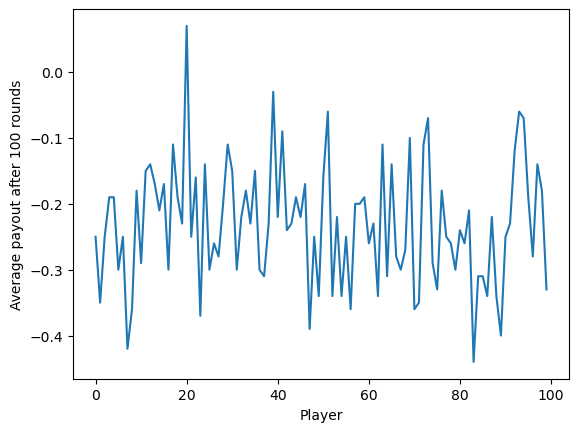

Average payout of a player after 100 rounds is -0.23220000000000002


-0.23220000000000002

In [35]:
#Payoff for Off-Policy MC Trained Policy
environment.reset()
calc_payoffs(environment,100,100,off_MC_Learned_Policy)

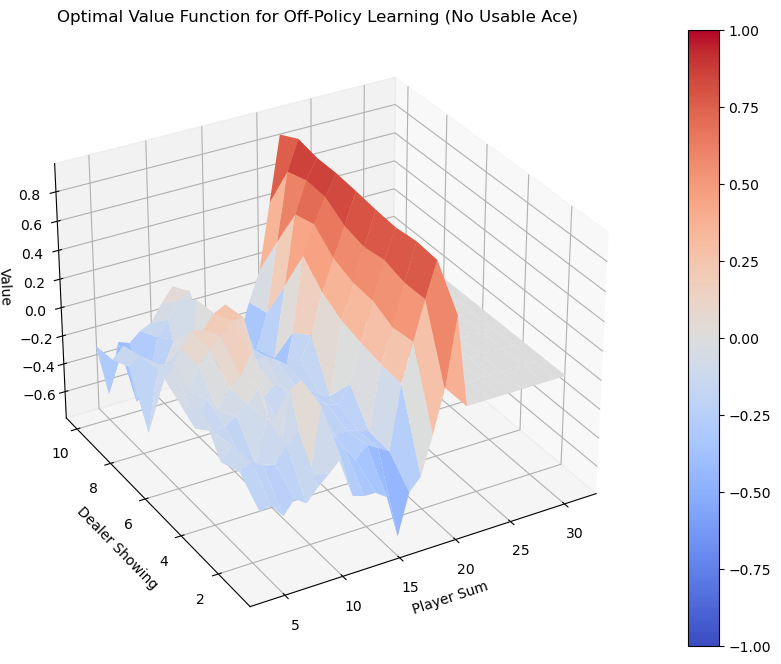

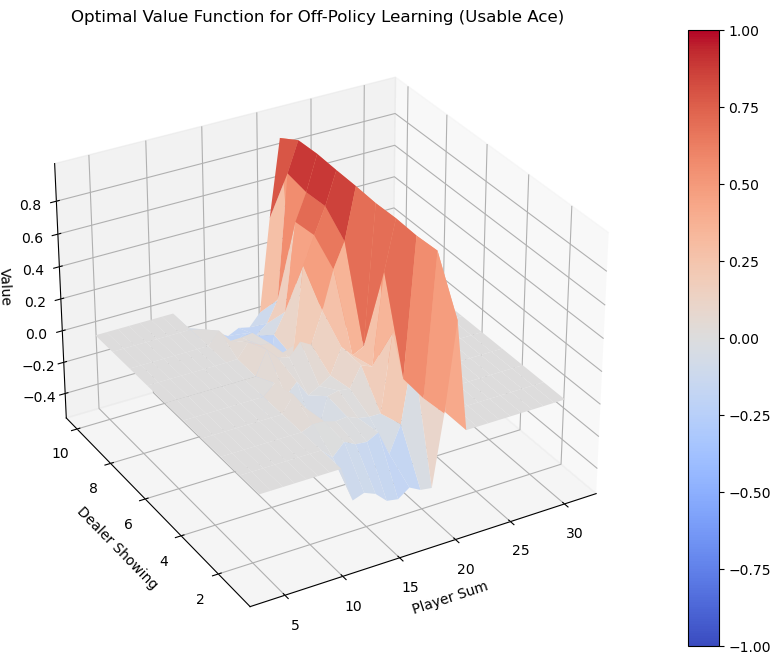

In [36]:
V = defaultdict(float)
for state, actions in Q_off_Pol.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function for Off-Policy Learning")

Off-Policy MC Learning Policy


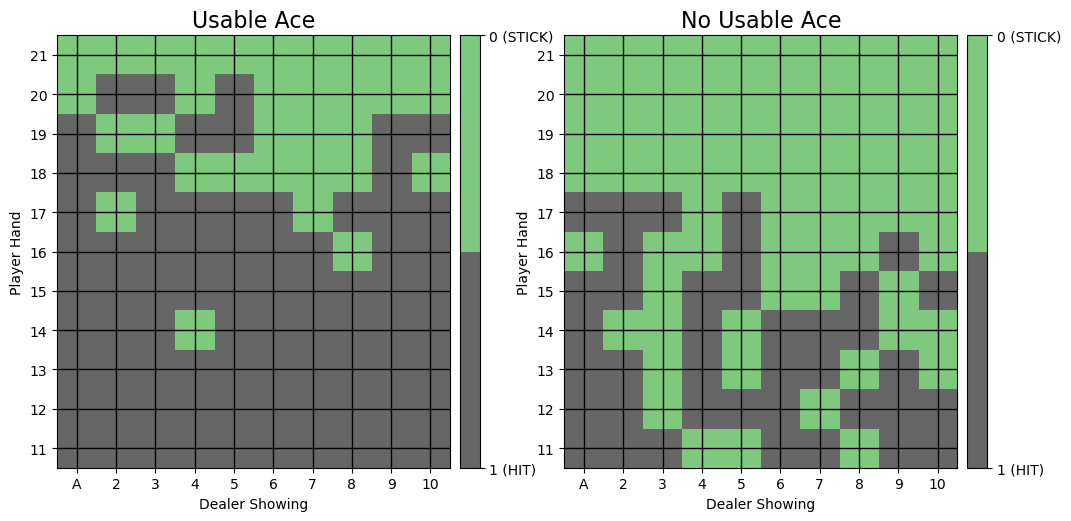

In [37]:
pol_test = {key: np.argmax(off_MC_Learned_Policy(key)) for key in Q_off_Pol.keys()}
print("Off-Policy MC Learning Policy")
plot_policy(pol_test)

### 4.3 Sarsa Learning (Temporal Difference control)

In [38]:
environment.reset()
Q_SARSA,SARSA_Policy = SARSA(environment, 500000, 0.1, 0.1,0.95)

Episode 500000/500000.

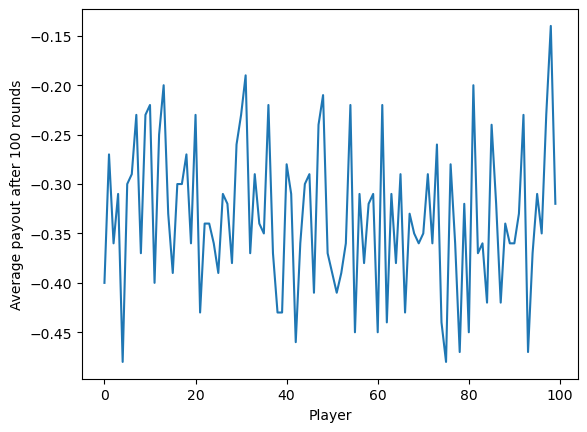

Average payout of a player after 100 rounds is -0.3336999999999999


-0.3336999999999999

In [39]:
#Payoff for Off-Policy MC Trained Policy
environment.reset()
calc_payoffs(environment,100,100,SARSA_Policy)

SARSA Learning Policy


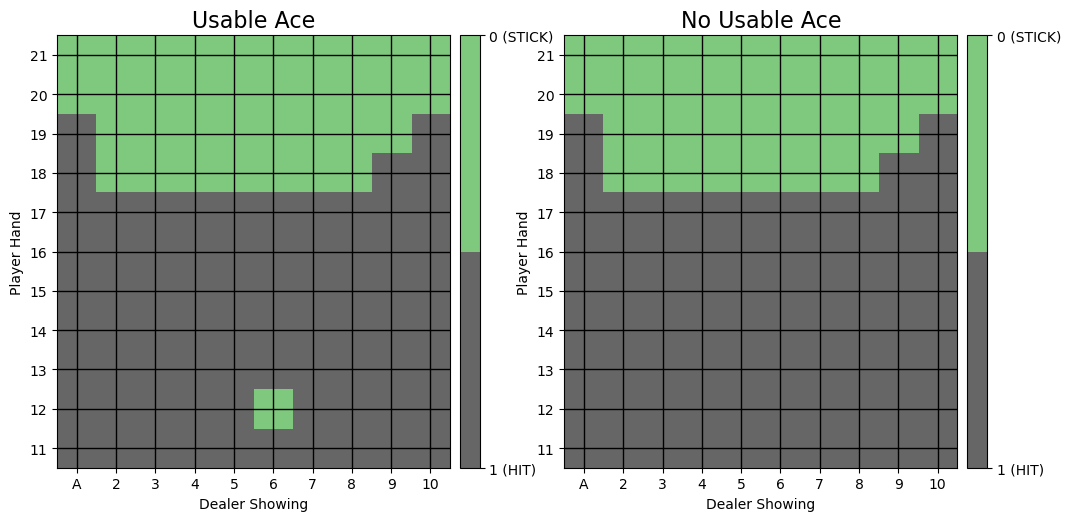

In [40]:
pol_sarsa = {key: np.argmax(SARSA_Policy(key)) for key in Q_SARSA.keys()}
print("SARSA Learning Policy")
plot_policy(pol_sarsa)

### 4.4 Q-Learning: Off-Policy TD

In [41]:
environment.reset()
Q_QLearn,QLearn_Policy = off_pol_TD_Q_learn(environment, 500000, 0.1, 0.1,0.95)

Episode 500000/500000.

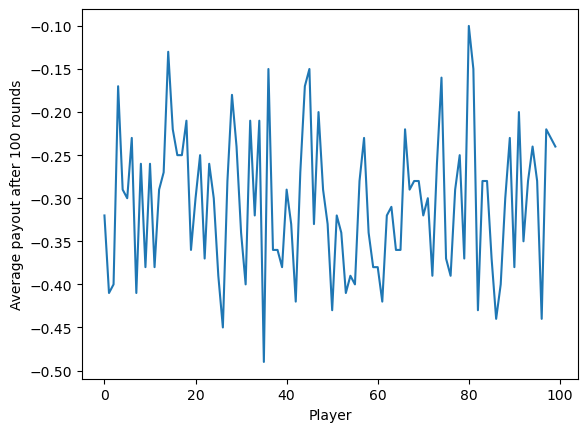

Average payout of a player after 100 rounds is -0.3049


-0.3049

In [42]:
#Payoff for Off-Policy Q-Learning Trained Policy
environment.reset()
calc_payoffs(environment,100,100,QLearn_Policy)

Off-Policy Q Learning Policy


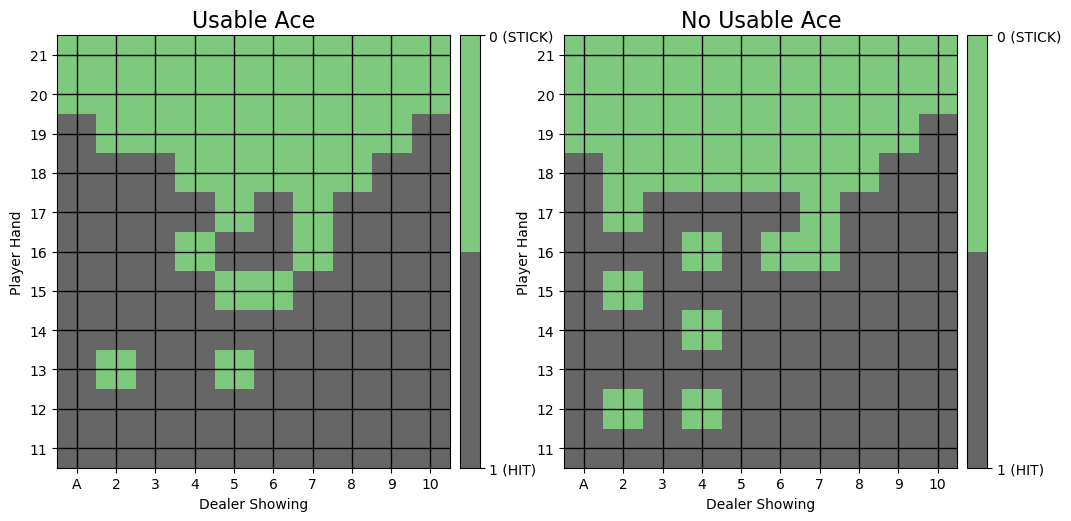

In [43]:
pol_QLearn = {key: np.argmax(QLearn_Policy(key)) for key in Q_QLearn.keys()}
print("Off-Policy Q Learning Policy")
plot_policy(pol_QLearn)